# Home assignment 3 (17 pts) 

## Only filled ipynb file should be submitted in Stepik!

## Problem 1. Control by landing of spaceship (10 pts)

Practical implementation of the ideas from this problem see [here](https://www.youtube.com/watch?v=2t15vP1PyoA)

In this problem we assume that the dynamic of spaceship controls by the Newton's second law

$$
mx''(t) = f(t) - mge_3,
$$

where $e_3$ is a vector $(0, 0, 1)$, $m$ is a mass that is constant by our assumption (otherwise we will get much complicated dynamic), $f(t)$ is a force that we can control, $x''(t)$ is acceleration.
We also skip the atmosphere affects.
This is vector equation, so $x(t)$ and $f(t)$ and 3D vectors in every timestamp. 

#### Dynamic equation we can get after discretization of the above equation

For speed we get

$$
m\frac{v_{k+1} - v_k}{h} = f_k - mge_3, \quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3
$$

and similarly for coordinates

$$
x' = v \quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

We use here Runge-Kutta method of the order 2, more details see [here](http://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node5.html).

The landing point has coordinates $(0, 0, 0)$ and for successful landing the final speed has to be zero. 
Also, during the landing it is important to prevent shift of the spaceshift in the vertical axis, so the $z$-coordinate can not be smaller than its projection on the plane $(x, y)$ in given factor

$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

Since force is created my engine that consumes fuel, we have some upper bound on the force

$$
\|f(t)\|_2 \leq F_{\max}.
$$

Also the amount of the consumed fuel can be computed by the following equation

$$
\gamma \int_0^T \|f(t)\|_2 dt,
$$

 where $\gamma$ is a fuel consumption coefficient, $T$ is a landing time. 
 
During time discretization we can assume that $f(t)$ is constant in every interval $[(k-1)h; kh]$ for $k=1,\ldots,K$. Thus, the total time for landing is $Kh$. 

**Task 1**
Find the position, speed and forse in evert timestamp such that the total amount of consumed fuel is minimal

1) (2 pts) State optimization problem formally. It means define the objective function, variables and constraints explicitly in mathematical way.

2) (3 pts) Solve it with CVXPy and visualize solution 

**Task 2**
Find the minimal time that is sufficient to land the spaceship. i.e. if the time discretization step $h$ is fixed, we need to find the minimal time to move spaceship from the initial point to the final point with final speed.
You can solve multiple auxilliary problem to solve this problem.

3) (5 pts) State optimization problem formally and simplify as much as possible

4) (4 pts) Solve it with CVXPy and visualize solution. Compare the resulted trajectory with the trajectory from the task 1. How much requirement of the minimal time increased the amount of consumed fuel?

In [1]:
!pip install scs==2.1.4

In [2]:
!sudo apt install texlive-fonts-recommended texlive-fonts-extra
!sudo apt install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre javascript-common libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import cvxpy as cvx

# Time discretiztion step
h = 1.
# Gravity acceleration. It is just demo value to scale the solution time!
g = 0.1
# Mass
m = 10.
# Maximum norm of forse
Fmax = 10.
# Initial position
p0 = np.array([50, 50, 100])
# Initial velocity
v0 = np.array([-10, 0, -10])
# Initial force
f0 = np.array([0, g, 0])
# Factor of minimum slope
alpha = 0.5
# Fuel consumption factor
gamma = 1.
# Number of discretization steps, i.e. final time equals K*h
K = 35

In [15]:
# Your solution is here

variables = []
constraints = []

e3 = np.array([0,0,1])

velocity = cvx.Variable(shape=(3,K))
position = cvx.Variable(shape=(3,K))
force = cvx.Variable(shape=(3,K))

fuel = 0
for t in range(K):
    fuel = fuel + gamma * h * cvx.norm(force[:,t], 2)

# Velocity starting and ending points
constraints.append(velocity[:,0] == v0)
constraints.append(velocity[:,-1] == 0)

# Position starting and ending points
constraints.append(position[:,0] == p0)
constraints.append(position[:,-1] == 0)

for t in range(K):

  if (t < K - 1):
    # Velocity dynamic equations
    constraints.append(velocity[:,t+1] == velocity[:,t] + h/m*force[:,t] - h*g*e3)

    # Positions dynamic equation
    constraints.append(position[:,t+1] == position[:,t] + h/2*(velocity[:,t] + velocity[:,t+1]))

  constraints.append(position[2,t] >= alpha * cvx.norm(position[:2,t], 2))

  # ∥f(t)∥2 ≤ Fmax
  constraints.append(cvx.norm(force[:,t], 2) <= Fmax)

prob = cvx.Problem(cvx.Minimize(fuel), constraints)
prob.solve(verbose=True, max_iters=500)

193.68880645639635

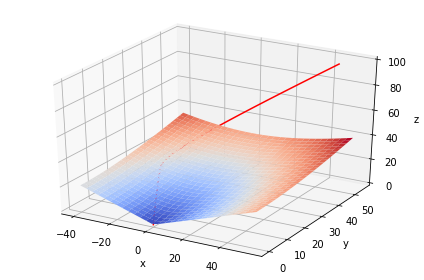

In [16]:
# use the following code to plot your trajectories
# and the glide cone
# -------------------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
#Have your solution be stored in p, which means positions
ax.plot(xs=position.value[0,:],ys=position.value[1,:],zs=position.value[2,:], c="red")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

$$
min \ \gamma \int_0^T \|f(t)\|_2 dt
$$

$$
Such \ that
$$

$$
m\frac{v_{k+1} - v_k}{h} = f_k - mge_3, \quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3
$$

$$
x' = v \quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

$$
\|f(t)\|_2 \leq F_{\max}.
$$


In [19]:
# Your solution is here

iterations = 100

for K in range(1, iterations):

  variables = []
  constraints = []

  e3 = np.array([0,0,1])

  velocity = cvx.Variable(shape=(3,K))
  positionT = cvx.Variable(shape=(3,K))
  force = cvx.Variable(shape=(3,K))

  fuel = 0
  for t in range(K):
      fuel = fuel + gamma * h * cvx.norm(force[:,t], 2)

  # Velocity starting and ending points
  constraints.append(velocity[:,0] == v0)
  constraints.append(velocity[:,-1] == 0)

  # Position starting and ending points
  constraints.append(positionT[:,0] == p0)
  constraints.append(positionT[:,-1] == 0)

  for t in range(K):

    if (t < K - 1):
      # Velocity dynamic equations
      constraints.append(velocity[:,t+1] == velocity[:,t] + h/m*force[:,t] - h*g*e3)

      # Positions dynamic equation
      constraints.append(positionT[:,t+1] == positionT[:,t] + h/2*(velocity[:,t] + velocity[:,t+1]))

    constraints.append(positionT[2,t] >= alpha * cvx.norm(positionT[:2,t], 2))

    # ∥f(t)∥2 ≤ Fmax
    constraints.append(cvx.norm(force[:,t], 2) <= Fmax)

  prob = cvx.Problem(cvx.Minimize(fuel), constraints)
  prob.solve(verbose=True, max_iters=500)

  if (prob.status == cvx.OPTIMAL):
    print(f"Minimal time taken = {(K - 1) * h}, fuel consumed = {fuel.value}")
    break

Minimal time taken = 25.0, fuel consumed = 245.63028969747847


In [ ]:
# The time constraint has increased the fuel consumption by the value ~ 52

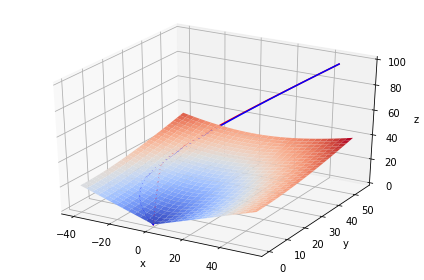

In [18]:
# use the following code to plot your trajectories
# and the glide cone
# -------------------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
#Have your solution be stored in p, which means positions
ax.plot(xs=position.value[0,:],ys=position.value[1,:],zs=position.value[2,:], c="red")
ax.plot(xs=positionT.value[0,:],ys=positionT.value[1,:],zs=positionT.value[2,:], c="blue")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

## Problem 2. Nonnegative matrix factorization (7 pts) 

__1.__ Download the the code below a dataset with photos and plot any of the samples.

In [11]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


Shape of data = (400, 64, 64)


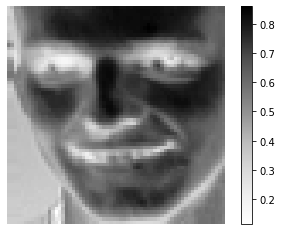

In [12]:
print("Shape of data = {}".format(data["images"].shape))
index = 45
plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

In [13]:
for i in data.keys():
  print(i)

print(data['data'].shape)
print(data['images'].shape)
print(data['target'].shape)


data
images
target
DESCR
(400, 4096)
(400, 64, 64)
(400,)


__2.__ One of the classical approach to image and in general signal processing is [nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)). 
Idea of the method is to solve the following optimization problem

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

where symbol $\geq$ denotes elementwise comparison. 
Also matrices $W$ and $H$ are lowrank, i.e. $W \in \mathbb{R}^{m \times k}$ and $H \in \mathbb{R}^{k \times n}$, where $k$ is a hyper-parameter that has to be tuned.
The larger $k$, the more accurate approximation, but more time is needed to solve the problem.
The matrix $X \in \mathbb{R}^{m \times n}$, where $m$ is a number of photos in our dataset, and $n$ is a umber of pixels in every picture, i.e. every row of the matrix $X$ is a vectorized image.

**Tasks**

1) (1 pts) is the above problem convex and why?

2) (1 pts) how can you interpret factors $W$ and $H$ and why its nonnegativity is important?

In [14]:
# Cell for your answer

# 1) It is not convex because the Hessian of the function is not positive semidefinite.

# 2) Columns of W are images that represent original image features.
#    Matrix H represents importance of certain features in W, so these are weights.
#    Their product represents an approximation to all images in X.
#    W and H have to be nonnegative because their linear approximation must be nonnegative,
#    as X is nonnegative, representing intensities of an image (that cannot be negative)

__3.__ This problem can be approximately solved with CVXPy if the alternating optimization is used. The idea of this method is in even iterations solve the problem w.r.t $W$ while the matrix $H$ is fixed and in the odd iterations use optimal value of $W$ from the previous iteration as a fixed matrix and solve the problem w.r.t. $H$. And keep such alternating until convergence w.r.t. the changing the objective function.
Before run this method you need to initialize matrices $W$ and $H$ with some non-negative elements, probably random. The quality of the solution and running time of the method crucially depend on the initialization. So, you can test different approaches and report result of your investigation additionally.

**Tasks**

1) (2 pts) implement with CVXPy the alternating optimization method for this problem and solve it for some reasonable fixed $k$

2) (1 pts) plot the convergence line (objective function value vs. iteration idx) and confirm that the method converegs or the changing in objective function with iterating is very small

3) (1 pts) since the dimension of matrix $H$ is $k \times n$, then every row of $H$ can be transformed to photo in the inverse manner like they were collected in rows of matrix $X$. Plot 10-50 pictures extracted from rows of matrix $H$. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use ```plt.colorbar()``` and colour scheme ```plt.cm.Greys``` for more constrast displaying the pixels

4) (1 pts) Plot matrix $W$ with functions ```plt.imshow``` or ```plt.spy``` from the ```matplotlib``` library. How much sparse is it?

In [15]:
print(cvx.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']


In [16]:
data['data'].shape[0]

400

In [18]:
# Cell for your code

images = data['data']

np.random.seed(0)

totalImages = images.shape[0]

m = 80
n = images.shape[1]
k = 10

W = np.random.rand(m, k)
H = np.random.rand(k, n)

iterations = 100

values = list()

minValue = float('inf')

minW = W
minH = H

# count = 0

X = images[:m,:]

for i in range(1, iterations):

    # count += 1

    # if ((count-1) * m > totalImages or count * m > totalImages):
    #   count = 1
      
    # lb = (count-1) * m
    # ub = count * m

    # print(f"Count = {count}. From {lb} to {ub}")

    # X = images[lb:ub,:]

    if i % 2 == 1:
        H = cvx.Variable(shape=(k, n))
        constraint = [H >= 0]
    else:
        W = cvx.Variable(shape=(m, k))
        constraint = [W >= 0]

    fx = 0.5 * (cvx.norm(X - W @ H, 'fro') ** 2)

    prob = cvx.Problem(cvx.Minimize(fx), constraint)
    prob.solve(verbose=True, solver="SCS", max_iters=1000)

    print(f"Status = {prob.status}. Iteration {i}, norm value = {prob.value}")
    
    values.append(prob.value)

    if i % 2 == 1:
        H = H.value
    else:
        W = W.value

    if (prob.value < minValue):
      minValue = prob.value

      minW = W
      minH = H



----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3317764
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 40962, constraints m = 368644
Cones:	linear vars: 40960
	soc vars: 327684, soc blks: 2
Setup time: 6.90e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.83e+21  1.04e+21  1.00e+00 -7.30e+22  9.08e+22  1.11e+23  7.72e-02 
   100| 1.36e+19  1.62e+19  3.46e-02  5.67e+21  5.29e+21  4.42e+19  7.42e+00 
   200| 6.61e-02  7.65e-02  8.38e-04  5.18e+03  5.17e+03  9.64e-16  1.46e+01 
   300

In [19]:
print(f"MinValue = {minValue}")
# Corresponding values:
# minH 
# minW

MinValue = 792.5367910585389


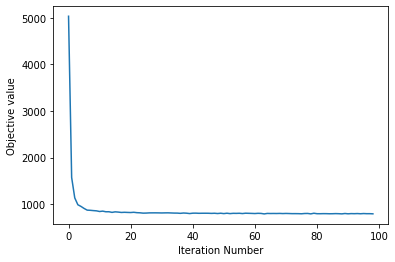

In [20]:
plt.plot(np.array(values))
plt.xlabel('Iteration Number')
plt.ylabel('Objective value')
plt.show()

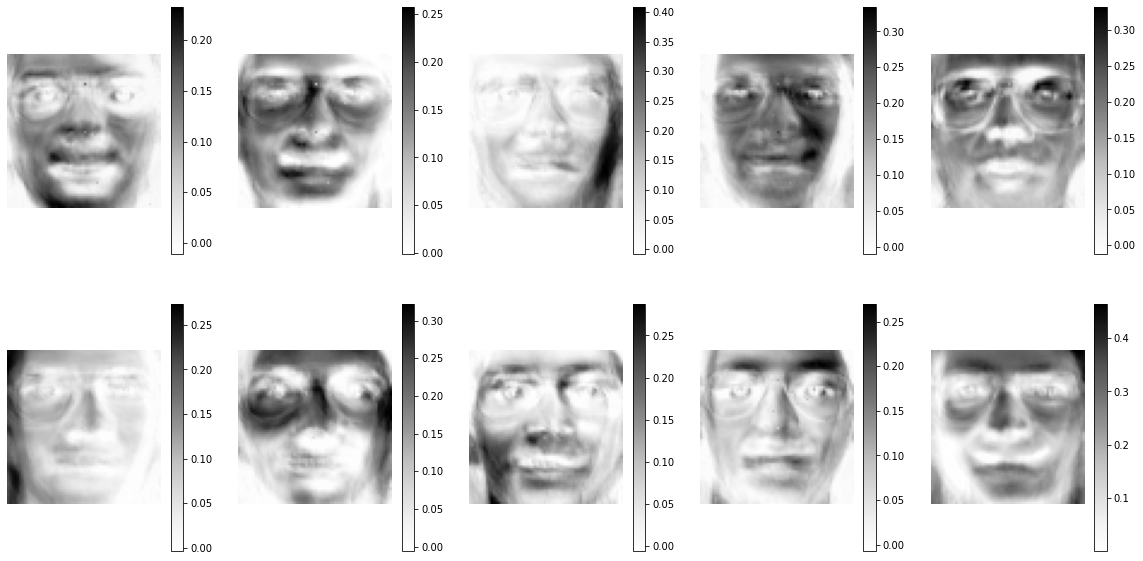

In [23]:
w = 2
h = 5
fig = plt.figure(figsize=(20, 10))
for i in range(1, w * h + 1):
    fig.add_subplot(w, h, i)
    plt.imshow(H.T[:,i - 1].reshape(64,64), cmap=plt.cm.Greys)
    plt.colorbar()
    _ = plt.axis("off")
plt.show()

In [ ]:
# The images seem sensible, they are not too far away from original -> objective is reached

(80, 10)


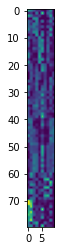

In [24]:
print(W.shape)
fig = plt.figure()
plt.imshow(W)
fig.show()

In [ ]:
# W is pretty sparse